# SARIMA Modeling

SARIMA (Seasonal ARIMA) extends the ARIMA model by incorporating seasonal components to better capture patterns that repeat at regular intervals, such as monthly or seasonally data.

In ARIMA, we observed that the next hour's value depends on previous hours' values and the errors that occurred during their predictions. In SARIMA, the same principle applies, but now the next hour's value also depends on some seasonal values (e.g., the value from last year, the year before that, and so on) as well as the errors that occurred during their predictions.

P specifies the number of seasons (seasonal values), Q determines the number of seasonal errors, and D specifies the number of seasonal differences. s specifies the length of a season. For example, if we consider a season to be a year, then **s = 24 × 365 = 8760**.

## Seasonal Components

In addition to the non-seasonal ARIMA parameters $(p, d, q)$, SARIMA includes seasonal parameters $(P, D, Q)_s$, where:

- **$P$ (Seasonal Autoregression):** Captures the relationship between the current value and its previous seasonal values.
  
  $$
  y_t = \alpha_1 y_{t-s} + \alpha_2 y_{t-2s} + \dots + \alpha_P y_{t-Ps} + \dots
  $$

- **$D$ (Seasonal Differencing):** Removes seasonal trends by differencing the series at the seasonal lag.
  
  $$
  y_t' = y_t - y_{t-s}
  $$

- **$Q$ (Seasonal Moving Average):** Models the dependency between the current value and past seasonal forecast errors.
  
  $$
  y_t = e_t + \beta_1 e_{t-s} + \beta_2 e_{t-2s} + \dots + \beta_Q e_{t-Qs} + \dots
  $$

- **$s$ (Seasonal Period):** The number of time steps in a seasonal cycle (e.g., $s=12$ for monthly data with yearly seasonality).

## SARIMA $(p, d, q) \times (P, D, Q)_s$ Model

The SARIMA model combines both non-seasonal and seasonal components:

$$
\Phi_P(B^s) \phi_p(B) (1 - B)^d (1 - B^s)^D y_t = \Theta_q(B) \Theta_Q(B^s) e_t
$$

Where:
- $\phi_p(B)$ and $\Theta_q(B)$ are the non-seasonal AR and MA polynomials.
- $\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are the seasonal AR and MA polynomials.
- $B$ is the backshift operator, $B y_t = y_{t-1}$.

## Fitting a SARIMA Model

To fit a SARIMA model:
1. **Determine $p$, $d$, $q$, $P$, $D$, $Q$, and $s$:** Analyze both non-seasonal and seasonal ACF (Auto-correlation Function) and PACF (Partial Auto-correlation Function) plots to identify appropriate orders.
2. **Estimate parameters:** Use Maximum Likelihood Estimation (MLE) to estimate both non-seasonal and seasonal parameters.
3. **Model validation:** Perform diagnostic checks, including residual analysis, to ensure both seasonal and non-seasonal components are well captured.
4. **Forecast:** Utilize the fitted SARIMA model to make forecasts that account for both trends and seasonality.

## Benefits of SARIMA

- **Captures Seasonality:** Effectively models data with strong seasonal patterns, which ARIMA alone may not handle well.
- **Improved Forecast Accuracy:** By accounting for seasonal effects, SARIMA often provides more accurate forecasts for seasonal time series.

SARIMA modeling extends ARIMA by adding seasonal autoregressive, differencing, and moving average components, allowing it to model and forecast data with seasonal patterns effectively.



In [3]:
# Here we need to use hourly data (a part of it, from about 3 months - 1 year to capture the seasonality).
# Change the name gaze_height to gauge_height.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product

import warnings
warnings.filterwarnings('ignore')

series_df = pd.read_csv('../dataset/chattahoochee_1mo_02336490.csv', 
                     usecols=['DATE', 'gaze_height'], 
                     header=0, 
                     index_col='DATE', 
                     parse_dates=True)

# it only works on univariate data
series = series_df['gaze_height']

# Split into train and test sets
size = int(len(series) * 0.66)
train, test = series.iloc[0:size], series.iloc[size:]


In [4]:
series_df

,gaze_height
DATE,
2010-01-31,9.097056
2010-02-28,12.159967
2010-03-31,9.677655
2010-04-30,6.249833
2010-05-31,8.520766
...,...
2024-01-31,6.605524
2024-02-29,7.172291
2024-03-31,9.395372


In [25]:
# the p, d, q parameters for the SARIMA model
# p: Autoregressive order
# d: Differencing order
# q: Moving average order
p = d = q = range(0, 3)  # p, d, q can be 0, 1, or 2

# Generate all different combinations of p, d, q triplets
pdq = list(product(p, d, q))

# seasonal p, d, q parameters for the SARIMA model
# Seasonal period is set to 12 (e.g., monthly data with yearly seasonality)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)  # Seasonal p, d, q can be 0 or 1
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in product(seasonal_p, seasonal_d, seasonal_q)]


In [27]:
# Grid search to find the optimal SARIMA parameters
def grid_search(train_data, pdq, seasonal_pdq):
    best_aic = np.inf  # Initialize the best AIC to infinity
    best_order = None
    best_seasonal_order = None

    # Iterate over all combinations of p, d, q parameters
    for param in pdq:
        # Iterate over all combinations of seasonal p, d, q parameters
        for seasonal_param in seasonal_pdq:
            try:
                # Fit SARIMAX model with the current parameters
                model = SARIMAX(train_data, 
                                order=param, 
                                seasonal_order=seasonal_param,
                                enforce_stationarity=True,
                                enforce_invertibility=False)
                results = model.fit(disp=False)

                # Check if the current model has the lowest AIC so far
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = seasonal_param
            except Exception as e:
                # If the model fails to fit, continue to the next parameter combination
                continue

    return best_order, best_seasonal_order

In [28]:
# initial grid search to find the best parameters on the training data
print("Performing initial grid search...")
best_order, best_seasonal_order = grid_search(train, pdq, seasonal_pdq)

print(f"Best SARIMA parameters: {best_order}")
print(f"Best seasonal parameters: {best_seasonal_order}")


#Explain about the seasonality, what value we chose and why we chose it.

Performing initial grid search...
Best SARIMA parameters: (1, 0, 0)
Best seasonal parameters: (0, 1, 1, 12)


In [32]:
# Walk-forward validation with rolling window
# We are doing validation with 33% of the dataset
window_size = 36  # three years of monthly data
history = train.iloc[-window_size:].copy()  
predictions = []

print("Performing walk-forward validation...")
for t in range(len(test)):
    # Fit SARIMAX model on the current window of data
    model = SARIMAX(history, 
                    order=best_order, 
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # the next time step

    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    
    # actual observation and its timestamp
    obs_value = test.iloc[t]
    obs_index = test.index[t]
    
    obs = pd.Series(obs_value, index=[obs_index])
    history = pd.concat([history, obs])
    history = history.iloc[-window_size:]  # Keep only the last 'window_size' data points
    
    if (t + 1) % 6 == 0:
        print(f"Re-evaluating parameters at step {t+1}")
        best_order, best_seasonal_order = grid_search(history, pdq, seasonal_pdq)
        print(f"Updated best SARIMA parameters: {best_order}")
        print(f"Updated best seasonal parameters: {best_seasonal_order}")


Performing walk-forward validation...


AttributeError: 'Series' object has no attribute 'reshape'

Test RMSE: 1.807


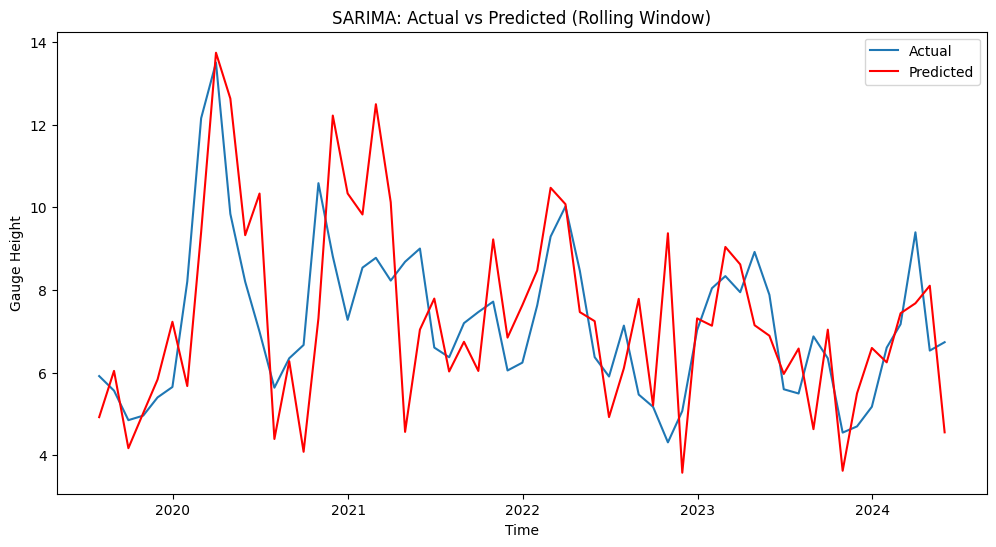

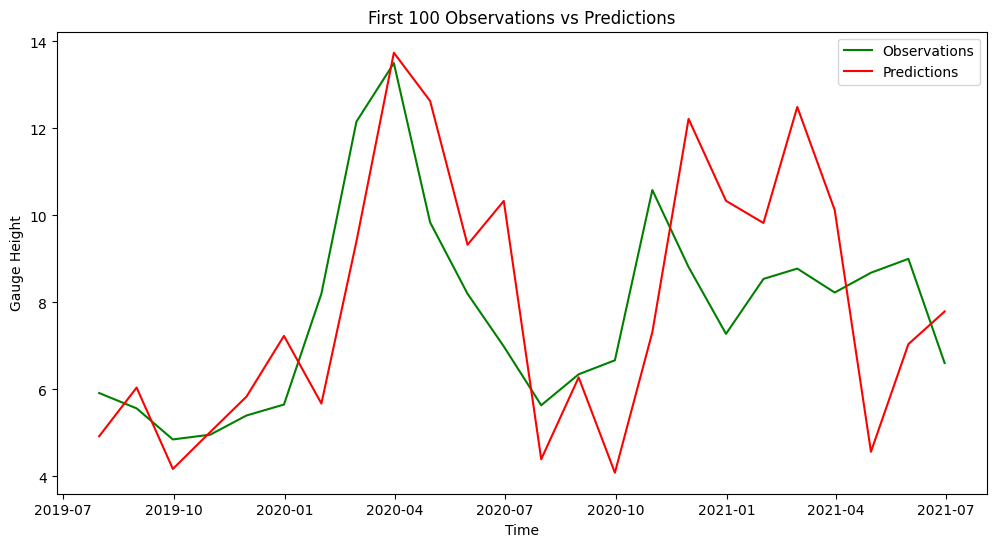

In [6]:
# Evaluate forecasts
rmse = sqrt(mean_squared_error(test.values, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.legend()
plt.title('SARIMA: Actual vs Predicted (Rolling Window)')
plt.xlabel('Time')
plt.ylabel('Gauge Height')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test.index[:24], test.values[:24], color='green', label='Observations')
plt.plot(test.index[:24], predictions[:24], color='red', linestyle='-', label='Predictions')
plt.legend()
plt.title('First 100 Observations vs Predictions')
plt.xlabel('Time')
plt.ylabel('Gauge Height')
plt.show()

In [7]:
# evaluation metrics
epsilon = np.finfo(float).eps  # Small number to avoid division by zero

def WAPE(y_true, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true)) + epsilon
    wape = (nominator / denominator) * 100.0
    return wape

def NSE(y_true, y_pred):
    """Nash-Sutcliffe Efficiency coefficient"""
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    nse_value = 1 - (numerator / denominator)
    return nse_value


wape = WAPE(test.values, predictions)
nse_value = NSE(test.values, predictions)
print(f'WAPE: {wape:.2f}%, NSE: {nse_value:.2f}')


WAPE: 19.86%, NSE: 0.03


In [23]:
s1 = pd.Series([[1],[2],[3],[4],[5]])

In [22]:
s1.shape

(5,)